In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### Install Environment
!pip install timm
!pip install faiss-gpu
!pip install wandb -qqq

import wandb
wandb.login()
wandb.init(project="test-project")

## Import Libraries

In [ ]:
import numpy as np 
import pandas as pd 

import os 
import cv2 
import warnings
import timm 

from torchvision import transforms

import torch 
import torch.nn.functional as F 
from torch import nn 
from torch.optim.optimizer import Optimizer
from torch.optim.lr_scheduler import _LRScheduler

from torch.utils.data import Dataset

import math

from tqdm.notebook import tqdm 
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

import copy
import random
from PIL import Image
import faiss
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json
import glob
import gc
import h5py

## Dataset

### Download Dataset

In [ ]:
%cd /content
!gdown --id 1vSheDwCkMBg-fwN3qmTL1pXT0rB_LLfj

path_data = '/content/data'
os.makedirs(path_data, exist_ok=True)

!tar -xvf /content/oxbuild_images-v1.tgz -C /content/data

Streaming output truncated to the last 5000 lines.
all_souls_000093.jpg
all_souls_000095.jpg
all_souls_000097.jpg
all_souls_000099.jpg
all_souls_000100.jpg
all_souls_000101.jpg
all_souls_000102.jpg
all_souls_000103.jpg
all_souls_000105.jpg
all_souls_000106.jpg
all_souls_000107.jpg
all_souls_000110.jpg
all_souls_000114.jpg
all_souls_000117.jpg
all_souls_000119.jpg
all_souls_000120.jpg
all_souls_000126.jpg
all_souls_000130.jpg
all_souls_000131.jpg
all_souls_000132.jpg
all_souls_000133.jpg
all_souls_000134.jpg
all_souls_000136.jpg
all_souls_000140.jpg
all_souls_000142.jpg
all_souls_000143.jpg
all_souls_000144.jpg
all_souls_000145.jpg
all_souls_000146.jpg
all_souls_000148.jpg
all_souls_000149.jpg
all_souls_000150.jpg
all_souls_000151.jpg
all_souls_000152.jpg
all_souls_000153.jpg
all_souls_000157.jpg
all_souls_000159.jpg
all_souls_000160.jpg
all_souls_000161.jpg
all_souls_000162.jpg
all_souls_000167.jpg
all_souls_000174.jpg
all_souls_000175.jpg
all_souls_000176.jpg
all_souls_000180.jpg
all_

### Format Data

In [ ]:
img_files = glob.glob('/content/data/*.jpg')

for file in img_files:
  folder_name = '_'.join(file.split('_')[:-1])
  os.makedirs(folder_name, exist_ok=True)
  os.system(f'mv {file} {folder_name}')

In [ ]:
folders = glob.glob('/content/data/*')
if '/content/data/data.txt' in folders:
  folders.remove('/content/data/data.txt')

with open('/content/data/data.txt', 'w') as f:
  f.write('id,landmark_id\n')
  for idx, folder in enumerate(folders):
    img_files = os.listdir(folder)
    for file in img_files:
      f.write(f"{file.split('.')[0]},{idx}\n")

In [ ]:
from sklearn.model_selection import train_test_split

with open("data/data.txt",'r') as file:
    lines = file.readlines()[1:]
    lines = [line.rstrip() for line in lines]

In [ ]:
train_list, val_list = train_test_split(lines, test_size=0.2, random_state=42, shuffle=True)

print("len(train_list): ", len(train_list))
print("len(val_list): ", len(val_list))

len(train_list):  4050
len(val_list):  1013


In [ ]:
if os.path.exists("data/train.txt"):
  os.remove("data/train.txt")
with open("data/train.txt", "a+") as ft:
  ft.write("id,landmark_id\n")
  for line in train_list:
    ft.write("{}\n".format(line))

In [ ]:
if os.path.exists("data/val.txt"):
  os.remove("data/val.txt")
with open("data//val.txt", "a+") as fv:
  fv.write("id,landmark_id\n")
  for line in val_list:
    fv.write("{}\n".format(line))

## DataLoader

In [ ]:
def img_path_from_id(id):
    split_id = id.split("_")
    sub_folder = "_".join(split_id[:-1])
    img_path = os.path.join(path_data,
                            sub_folder, f'{id}.jpg')
    return img_path

class LmkRetrDataset(Dataset):
    def __init__(self, file_name):
        self.df = pd.read_csv(os.path.join(path_data, file_name), header=0)
        self.landmark_id_encoder = preprocessing.LabelEncoder()
        self.df['landmark_id'] = self.landmark_id_encoder.fit_transform(
            self.df['landmark_id'])
        self.df['path'] = self.df['id'].apply(img_path_from_id)
        self.paths = self.df['path'].values
        self.ids = self.df['id'].values
        self.landmark_ids = self.df['landmark_id'].values

    def __len__(self):
        return len(self.df)
      
    def __getitem__(self, idx):
        path, id, landmark_id = self.paths[idx], self.ids[idx], self.landmark_ids[idx]

        try:  
          img = cv2.imread(path)
          image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          
          MEAN = [0.485, 0.456, 0.406]
          STD = [0.229, 0.224, 0.225]

          transform = transforms.Compose([
              transforms.ToPILImage(),
              transforms.Resize((384, 384)),
              transforms.ToTensor(),
              transforms.Normalize(MEAN, STD),
          ])

          img = transform(img)
        except Exception as e:
          print("image error: ", path)
          assert "error"

        return {
            'image' : img,
            'label' : torch.tensor(landmark_id)
        }

## Optimize

In [ ]:
class ModelIRScheduler(_LRScheduler):
    def __init__(self, optimizer, lr_start=5e-6, lr_max=1e-5,
                 lr_min=1e-6, lr_ramp_ep=5, lr_sus_ep=0, lr_decay=0.8,
                 last_epoch=-1):
        self.lr_start = lr_start
        self.lr_max = lr_max
        self.lr_min = lr_min
        self.lr_ramp_ep = lr_ramp_ep
        self.lr_sus_ep = lr_sus_ep
        self.lr_decay = lr_decay
        super(ModelIRScheduler, self).__init__(optimizer, last_epoch)
        
    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)
        
        if self.last_epoch == 0:
            self.last_epoch += 1
            return [self.lr_start for _ in self.optimizer.param_groups]
        
        lr = self._compute_lr_from_epoch()
        self.last_epoch += 1
        
        return [lr for _ in self.optimizer.param_groups]
    
    def _get_closed_form_lr(self):
        return self.base_lrs
    
    def _compute_lr_from_epoch(self):
        if self.last_epoch < self.lr_ramp_ep:
            lr = ((self.lr_max - self.lr_start) / 
                  self.lr_ramp_ep * self.last_epoch + 
                  self.lr_start)
        
        elif self.last_epoch < self.lr_ramp_ep + self.lr_sus_ep:
            lr = self.lr_max
            
        else:
            lr = ((self.lr_max - self.lr_min) * self.lr_decay**
                  (self.last_epoch - self.lr_ramp_ep - self.lr_sus_ep) + 
                  self.lr_min)
        return lr

In [ ]:
def centralized_gradient(x, use_gc=True, gc_conv_only=False):
    if use_gc:
        if gc_conv_only:
            if len(list(x.size())) > 3:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))), keepdim=True))
        else:
            if len(list(x.size())) > 1:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))), keepdim=True))
    return x


class Ranger(Optimizer):
    def __init__(self, params, lr=1e-3,                       # lr
                 alpha=0.5, k=5, N_sma_threshhold=5,           # Ranger options
                 betas=(.95, 0.999), eps=1e-5, weight_decay=0,  # Adam options
                 # Gradient centralization on or off, applied to conv layers only or conv + fc layers
                 use_gc=True, gc_conv_only=False, gc_loc=True
                 ):

        # parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')
 
        # parameter comments:
        # beta1 (momentum) of .95 seems to work better than .90...
        # N_sma_threshold of 5 seems better in testing than 4.
        # In both cases, worth testing on your dataset (.90 vs .95, 4 vs 5) to make sure which works best for you.

        # prep defaults and init torch.optim base
        defaults = dict(lr=lr, alpha=alpha, k=k, step_counter=0, betas=betas,
                        N_sma_threshhold=N_sma_threshhold, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

        # adjustable threshold
        self.N_sma_threshhold = N_sma_threshhold

        # look ahead params

        self.alpha = alpha
        self.k = k

        # radam buffer for state
        self.radam_buffer = [[None, None, None] for ind in range(10)]

        # gc on or off
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only
        # level of gradient centralization
        #self.gc_gradient_threshold = 3 if gc_conv_only else 1

        print(
            f"Ranger optimizer loaded. \nGradient Centralization usage = {self.use_gc}")
        if (self.use_gc and self.gc_conv_only == False):
            print(f"GC applied to both conv and fc layers")
        elif (self.use_gc and self.gc_conv_only == True):
            print(f"GC applied to conv layers only")

    def __setstate__(self, state):
        print("set state called")
        super(Ranger, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        # note - below is commented out b/c I have other work that passes back the loss as a float, and thus not a callable closure.
        # Uncomment if you need to use the actual closure...

        # if closure is not None:
        #loss = closure()

        # Evaluate averages and grad, update param tensors
        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()

                if grad.is_sparse:
                    raise RuntimeError(
                        'Ranger optimizer does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]  # get state dict for this param

                if len(state) == 0:  # if first time to run...init dictionary with our desired entries
                    # if self.first_run_check==0:
                    # self.first_run_check=1
                    #print("Initializing slow buffer...should not see this at load from saved model!")
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)

                    # look ahead weight storage now in state dict
                    state['slow_buffer'] = torch.empty_like(p.data)
                    state['slow_buffer'].copy_(p.data)
                
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                # begin computations
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # GC operation for Conv layers and FC layers
                # if grad.dim() > self.gc_gradient_threshold:
                #    grad.add_(-grad.mean(dim=tuple(range(1, grad.dim())), keepdim=True))
                if self.gc_loc:
                    grad = centralized_gradient(grad, use_gc=self.use_gc, gc_conv_only=self.gc_conv_only)

                state['step'] += 1

                # compute variance mov avg
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # compute mean moving avg
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                buffered = self.radam_buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * \
                        state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > self.N_sma_threshhold:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (
                            N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                # if group['weight_decay'] != 0:
                #    p_data_fp32.add_(-group['weight_decay']
                #                     * group['lr'], p_data_fp32)

                # apply lr
                if N_sma > self.N_sma_threshhold:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom
                else:
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p_data_fp32, alpha=group['weight_decay'])
                # GC operation
                if self.gc_loc == False:
                    G_grad = centralized_gradient(G_grad, use_gc=self.use_gc, gc_conv_only=self.gc_conv_only)

                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                p.data.copy_(p_data_fp32)

                # integrated look ahead...
                # we do it at the param level instead of group level
                if state['step'] % group['k'] == 0:
                    # get access to slow param tensor
                    slow_p = state['slow_buffer']
                    # (fast weights - slow weights) * alpha
                    slow_p.add_(p.data - slow_p, alpha=self.alpha)
                    # copy interpolated weights to RAdam param tensor
                    p.data.copy_(slow_p)

        return loss

In [ ]:
''' I just wanted to understand and implement custom backward activation in PyTorch so I choose this.
    You can also simply use this function below too.

class Mish(nn.Module):
    def __init__(self):
        super(Mish, self).__init__()

    def forward(self, input):
        return input * (torch.tanh(F.softplus(input)))
'''

class Mish_func(torch.autograd.Function):    
    @staticmethod
    def forward(ctx, i):
        result = i * torch.tanh(F.softplus(i))
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
  
        v = 1. + i.exp()
        h = v.log() 
        grad_gh = 1./h.cosh().pow_(2) 

        # Note that grad_hv * grad_vx = sigmoid(x)
        #grad_hv = 1./v  
        #grad_vx = i.exp()
        
        grad_hx = i.sigmoid()

        grad_gx = grad_gh *  grad_hx #grad_hv * grad_vx 
        
        grad_f =  torch.tanh(F.softplus(i)) + i * grad_gx 
        
        return grad_output * grad_f 

class Mish(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        print("Mish initialized")
        pass
    def forward(self, input_tensor):
        return Mish_func.apply(input_tensor)

In [ ]:
def replace_activations(model, existing_layer, new_layer):
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            model._modules[name] = replace_activations(module, existing_layer, new_layer)

        if type(module) == existing_layer:
            layer_old = module
            layer_new = new_layer
            model._modules[name] = layer_new
    return model

## ArcMargin Product

In [ ]:
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, scale=30.0, margin=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.scale = scale
        self.margin = margin
        self.ls_eps = ls_eps  # label smoothing
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.th = math.cos(math.pi - margin)
        self.mm = math.sin(math.pi - margin) * margin

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.scale

        return output, nn.CrossEntropyLoss()(output,label)

## IRModel

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [ ]:
class IRModel(nn.Module):
    def __init__(self, n_classes = 17, model_name = 'resnext50_32x4d', fc_dim = 512,
                  margin = 0.5, scale = 30, use_fc = True, pretrained = True):
        super(IRModel,self).__init__()
        print('Building Model Backbone for {} model'.format(model_name))

        self.backbone = timm.create_model(model_name, pretrained=pretrained)

        if model_name == 'resnext50_32x4d':
            final_in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
            self.backbone.global_pool = nn.Identity()

        elif 'efficientnet' in model_name:
            final_in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
            self.backbone.global_pool = nn.Identity()
        
        elif 'nfnet' in model_name:
            final_in_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()
            self.backbone.head.global_pool = nn.Identity()

        elif 'vit_base_resnet50_384' in model_name:
            final_in_features = self.backbone.head.in_features
            self.backbone.head = nn.Identity()

        self.pooling =  nn.AdaptiveAvgPool2d(1)

        self.use_fc = use_fc

        if use_fc:
            self.dropout = nn.Dropout(p=0.0)
            self.fc = nn.Linear(final_in_features, fc_dim)
            self.bn = nn.BatchNorm1d(fc_dim)
            self._init_params()
            final_in_features = fc_dim

        self.final = ArcMarginProduct(
            final_in_features,
            n_classes,
            scale = scale,
            margin = margin,
            easy_margin = False,
            ls_eps = 0.0
        )

    def _init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, image, label):
        feature = self.extract_feat(image)
        logits = self.final(feature,label)
        return logits
    
    def predict(self, image):
        feature = self.extract_feat(image)
        return feature

    def extract_feat(self, x):
        batch_size = x.shape[0]
        x = self.backbone(x)
        if len(x.shape) > 2:
          x = self.pooling(x).view(batch_size, -1)

        if self.use_fc:
            x = self.dropout(x)
            x = self.fc(x)
            x = self.bn(x)
        return x

## Train 

In [ ]:
def train_fn(model, data_loader, optimizer, scheduler, i):
    model.train()
    fin_loss = 0.0
    tk = tqdm(data_loader, desc = "Epoch" + " [TRAIN] " + str(i+1))

    for t,data in enumerate(tk):
        for k,v in data.items():
            data[k] = v.to(device)
        optimizer.zero_grad()
        _, loss = model(**data)
        loss.backward()
        optimizer.step() 
        fin_loss += loss.item() 

        tk.set_postfix({'loss' : '%.6f' %float(fin_loss/(t+1)), 'LR' : optimizer.param_groups[0]['lr']})

    scheduler.step()

    return fin_loss / len(data_loader)

def eval_fn(model, data_loader, i):
    model.eval()
    fin_loss = 0.0
    tk = tqdm(data_loader, desc = "Epoch" + " [VALID] " + str(i+1))

    with torch.no_grad():
        for t,data in enumerate(tk):
            for k,v in data.items():
                data[k] = v.to(device)
            _, loss = model(**data)
            fin_loss += loss.item() 

            tk.set_postfix({'loss' : '%.6f' %float(fin_loss/(t+1))})
        return fin_loss / len(data_loader)

In [ ]:
path_data = '/content/drive/MyDrive/AIC_2022/Dataset/images'
transformed_train_data = LmkRetrDataset('/content/drive/MyDrive/AIC_2022/Dataset/images/train.txt')
transformed_val_data = LmkRetrDataset('/content/drive/MyDrive/AIC_2022/Dataset/images/val.txt')
train_data_loader = torch.utils.data.DataLoader(transformed_train_data, batch_size=16, shuffle=True, num_workers=2)
val_data_loader = torch.utils.data.DataLoader(transformed_val_data, batch_size=16, shuffle=False, num_workers=2)

In [ ]:
# timm.list_models(filter='*resnext50_32x4d*')

In [ ]:
# Supported: vit_base_resnet50_384, tf_efficientnet_b5, tf_efficientnet_b5_ns, tf_efficientnet_b6, tf_efficientnet_b7
# nfnet_f6, nfnet_f7, resnext50_32x4d
model_name = 'vit_base_resnet50_384'
model = IRModel(model_name=model_name, n_classes=133).to(device)
existing_layer = torch.nn.SiLU
new_layer = Mish()
model = replace_activations(model, existing_layer, new_layer)

Building Model Backbone for vit_base_resnet50_384 model
Mish initialized


In [ ]:
SCHEDULER_PARAMS = {
            "lr_start": 1e-5,
            "lr_max": 1e-5 * 32,
            "lr_min": 1e-6,
            "lr_ramp_ep": 5,
            "lr_sus_ep": 0,
            "lr_decay": 0.8,
        }

optimizer = Ranger(model.parameters(), lr = SCHEDULER_PARAMS['lr_start'])
scheduler = ModelIRScheduler(optimizer,**SCHEDULER_PARAMS)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


In [ ]:
os.makedirs('/content/drive/MyDrive/AIC_2022/ArcMargin/saved', exist_ok=True)
%cd /content/drive/MyDrive/AIC_2022/ArcMargin

for i in range(10):
    avg_loss_train = train_fn(model, train_data_loader, optimizer, scheduler, i)
    avg_loss_val = eval_fn(model, val_data_loader, i)
    wandb.log({'loss_val':avg_loss_val,'loss_train':avg_loss_train})
    torch.save(model.state_dict(),'saved/IR_ViT_model_epoch_{}.pt'.format(i))

avg_loss_train = train_fn(model, train_data_loader, optimizer, scheduler, i+1)
torch.save(model.state_dict(),'saved/IR_ViT_model2.pt')

/content/drive/MyDrive/AIC_2022/ArcMargin


Epoch [TRAIN] 1:   0%|          | 0/939 [00:00<?, ?it/s]

Epoch [VALID] 1:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [TRAIN] 2:   0%|          | 0/939 [00:00<?, ?it/s]

Epoch [VALID] 2:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [TRAIN] 3:   0%|          | 0/939 [00:00<?, ?it/s]

Epoch [VALID] 3:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [TRAIN] 4:   0%|          | 0/939 [00:00<?, ?it/s]

Epoch [VALID] 4:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [TRAIN] 5:   0%|          | 0/939 [00:00<?, ?it/s]

Epoch [VALID] 5:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [TRAIN] 6:   0%|          | 0/939 [00:00<?, ?it/s]

Epoch [VALID] 6:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [TRAIN] 7:   0%|          | 0/939 [00:00<?, ?it/s]

Epoch [VALID] 7:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [TRAIN] 8:   0%|          | 0/939 [00:00<?, ?it/s]

Epoch [VALID] 8:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [TRAIN] 9:   0%|          | 0/939 [00:00<?, ?it/s]

Epoch [VALID] 9:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [TRAIN] 10:   0%|          | 0/939 [00:00<?, ?it/s]

Epoch [VALID] 10:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [TRAIN] 11:   0%|          | 0/939 [00:00<?, ?it/s]

## Post Processing

### Required Function


In [ ]:
class Load_Images(Dataset):
    def __init__(self, list_paths):
        self.paths = list_paths

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        MEAN = [0.485, 0.456, 0.406]
        STD = [0.229, 0.224, 0.225]

        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((384, 384)),
            transforms.ToTensor(),
            transforms.Normalize(MEAN, STD),
        ])
    
        img = transform(img)

        return img, torch.tensor(1)

In [ ]:
def show_imgs(query, matches_path):
  """
  It takes in a query image and a list of filepaths to images, and displays the query image and the
  top 6 images from the list of filepaths
  
  :param query: the image we want to find similar images to
  :param matches_path: the list of file ids of the images that are most similar to the query image
  """
  plt.axis("off")
  plt.imshow(query)
  fig = plt.figure(figsize=(14,14))
  columns = 5
  rows = 4
  try:
    for i in range(1, columns*rows +1):
      img = mpimg.imread(matches_path[i])
      ax = fig.add_subplot(rows, columns, i)
      plt.imshow(img)
      plt.axis("off")
    plt.show()
  except: 
    pass

In [ ]:
def inference(query_path, model, index):
  """
  Given a query image, we use the retrieval function to extract the feature vector of the query image.
  Then, we use the index to search for the top-k nearest neighbors of the query image
  
  :param query_path: the path to the query image
  :param retrieval_func: The function that will be used to retrieve the embedding of the query image
  :param index: the index object that we created earlier
  """
  img = cv2.imread(query_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  MEAN = [0.485, 0.456, 0.406]
  STD = [0.229, 0.224, 0.225]

  transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((384, 384)),
            transforms.ToTensor(),
            transforms.Normalize(MEAN, STD),
        ])
    
  img = transform(img)
  img = np.expand_dims(img, axis = 0)
  img = torch.tensor(img).cuda()
  feat = model(img)
  query_embed = feat.detach().cpu().numpy()
  scores, idx_image = index.search(query_embed, k=40)
  print(scores.shape)
  return scores[0], idx_image[0]

In [ ]:
def get_image_embeddings(list_paths, model):
    embeds = []
    image_dataset = Load_Images(list_paths)
    image_loader = torch.utils.data.DataLoader(
        image_dataset,
        batch_size=8,
        pin_memory=True,
        drop_last=False,
        num_workers=0
    )
    
    with torch.no_grad():
        for img,_ in tqdm(image_loader): 
            img = img.cuda()
            feat = model.predict(img)
            image_embed = feat.detach().cpu().numpy()
            embeds.append(image_embed)
    
    
    # del model
    image_embeddings = np.concatenate(embeds)
    print(f'Our image embeddings shape is {image_embeddings.shape}')
    del embeds
    gc.collect()
    return image_embeddings

### Reranking(NB) Top1 Shopee

In [ ]:
class Reranking1_Shoppe():
  def __init__(self,):
      pass

  def l2norm_numpy(self,x):
      return x / np.linalg.norm(x, ord=2, axis=1, keepdims=True)

  def neighborhood_search(self,emb,thresh,k_neighbors):
      index = faiss.IndexFlatIP(emb.shape[1])
      faiss.normalize_L2(emb)
      index.add(emb)
      sim, I = index.search(emb, k_neighbors)
      pred_index=[]
      pred_sim=[]
      for i in range(emb.shape[0]):
          cut_index=0
          for j in sim[i]:
              if(j>thresh):
                  cut_index+=1
              else:
                  break                        
          pred_index.append(I[i][:(cut_index)])
          pred_sim.append(sim[i][:(cut_index)])
          
      return pred_index,pred_sim
    
  def blend_neighborhood(self,emb, match_index_lst, similarities_lst):
      new_emb = emb.copy()
      for i in range(emb.shape[0]):
          cur_emb = emb[match_index_lst[i]]
          weights = np.expand_dims(similarities_lst[i], 1)
          new_emb[i] = (cur_emb * weights).sum(axis=0)
      new_emb = self.l2norm_numpy(new_emb)
    
      return new_emb

  def iterative_neighborhood_blending(self,emb, threshes,k_neighbors):
      for thresh in threshes:
          match_index_lst, similarities_lst = self.neighborhood_search(emb, thresh,k_neighbors)
          emb = self.blend_neighborhood(emb, match_index_lst, similarities_lst)
      return emb, match_index_lst

In [ ]:
model = IRModel(model_name=model_name)
model.eval()
model = replace_activations(model, torch.nn.SiLU, Mish())
model.load_state_dict(torch.load("/content/saved/IR_ViT_model2.pt"))
model = model.to(device)

Building Model Backbone for vit_base_resnet50_384 model
Mish initialized


In [ ]:
# Creating a dictionary of image file paths.
path_data = '/content/data'
root_img_path = '/content/data'
df = pd.read_csv(os.path.join(root_img_path, 'train.txt'), header=0)
files = df['id'].apply(img_path_from_id)
ids_train = df['id']
max_len = len(max(ids_train, key = lambda x: len(x)))
feats_train = get_image_embeddings(files, model)

with h5py.File('/content/data/faiss.h5', 'w') as f:
    f.create_dataset('ids', data=np.array(ids_train, dtype=f'S{max_len}'))
    f.create_dataset('feats', data=feats_train)

  0%|          | 0/507 [00:00<?, ?it/s]

Our image embeddings shape is (4050, 512)


In [ ]:
reranking = Reranking1_Shoppe()
# Remember add feats_train and feats_test
threshes = [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8] # Adjust thresholds
result_emb, match_index_lst = reranking.iterative_neighborhood_blending(feats_train, threshes,k_neighbors=2)

In [ ]:
# Shos id and len of matches
match_dict = {idx:len(value) for idx, value in enumerate(match_index_lst)}
match_dict= list(sorted(match_dict.items(), key=lambda x:x[1], reverse = True))

In [ ]:
index_query = 506
id_query = ids_train[index_query]
img_query = cv2.imread(os.path.join(path_data, '_'.join(id_query.split('_')[:-1]), id_query+".jpg"))
img_query = cv2.cvtColor(img_query, cv2.COLOR_BGR2RGB)

indexes_sim = match_index_lst[index_query]
id_sim = [ids_train[idx] for idx in indexes_sim]
matches_path = [os.path.join(path_data, '_'.join(id_match.split('_')[:-1]), id_match+".jpg") for id_match in id_sim]
show_imgs(img_query, matches_path)

## Query images 

In [ ]:
# Creating a dictionary of image file paths.
root_img_path = 'data'
df = pd.read_csv(os.path.join(root_img_path, 'train.txt'), header=0)
files = df['id'].apply(img_path_from_id)
id2img_fps = dict(enumerate(files))
with open(os.path.join(root_img_path, 'image_path.json'), 'w') as f:
  f.write(json.dumps(id2img_fps))

In [ ]:
### Load index Images
def jsonKeys2int(js):
    """
    It takes a json file and converts all the keys to integers
    
    :param js: the json file
    :return: A dictionary with the keys as integers and the values as the image file paths.
    """
    if isinstance(js, dict):
            return {int(k):v for k,v in js.items()}
    return js

with open(os.path.join(root_img_path, 'image_path.json'), 'r') as f:
  id2img_fps = jsonKeys2int(json.loads(f.read()))

In [ ]:
# It takes a retrieval function and a database of images, and returns a faiss index
class my_faiss():
  def __init__(self, retrieval_func, model):
    self.retrieval_func = retrieval_func
    self.model = model
  
  def __call__(self, DB):
    embeddings = self.retrieval_func(DB, self.model)
    self.index = faiss.IndexFlatL2(embeddings.shape[1])
    self.index.add(embeddings)
    return self.index

In [ ]:
### Create bin file
model = Loaded_IRModel(model_name = 'vit_base_resnet50_384')
model.eval()
model = replace_activations(model, torch.nn.SiLU, Mish())
model.load_state_dict(torch.load("saved/IR_ViT_model.pt"))
model = model.to(device)

normal_faiss = my_faiss(get_image_embeddings, model)
normal_idx = normal_faiss(id2img_fps)

Building Model Backbone for vit_base_resnet50_384 model
Mish initialized


  0%|          | 0/100 [00:00<?, ?it/s]

Our image embeddings shape is (800, 512)


In [ ]:
#### Save bin file ####
faiss.write_index(normal_idx, os.path.join(root_img_path, 'faiss_normal_ViT.bin'))

In [ ]:
#### Or use can load Index by bin file ####
normal_idx = faiss.read_index(os.path.join(root_img_path, 'faiss_normal_ViT.bin'))

In [ ]:
### Inference
df = pd.read_csv(os.path.join(root_img_path, 'val.txt'), header=0)

files = df['id'].apply(img_path_from_id)
query_path = files[20]

landmark_id_files = df['landmark_id']
query_id = landmark_id_files[20]

normal_scores, normal_ids = inference(query_path, model, normal_idx)

print(f"scores: {(normal_scores)}")
print(f"idx: {normal_ids}")

(1, 40)
scores: [37.486416 39.275234 42.169827 43.95484  44.37775  44.65021  45.4984
 45.582523 45.590942 45.9599   46.39181  46.974632 47.36051  47.42457
 47.47956  47.60728  47.776478 47.817917 47.9855   48.081264 48.97991
 49.513874 49.72629  50.5722   50.69539  51.20033  51.98306  53.01281
 53.979446 54.282623 54.293335 54.5276   55.219807 55.460762 56.75001
 58.12574  58.54834  59.758507 60.05369  61.493626]
idx: [306 466 761 257 752 619 343 744  70 387 746 779 580 480 125  68 590 559
 268 161 608 392 496 404 262 713 456 330 666 109 471 244 123 550 348 137
 346 492 415 379]


306
data/train/bodleian/bodleian_000381.jpg
466
data/train/bodleian/bodleian_000429.jpg
761
data/train/bodleian/bodleian_000150.jpg
257
data/train/bodleian/bodleian_000165.jpg
752
data/train/bodleian/bodleian_000258.jpg
619
data/train/bodleian/bodleian_000163.jpg
343
data/train/bodleian/bodleian_000067.jpg
744
data/train/bodleian/bodleian_000425.jpg
70
data/train/bodleian/bodleian_000294.jpg
387
data/train/bodleian/bodleian_000009.jpg
746
data/train/bodleian/bodleian_000419.jpg
779
data/train/bodleian/bodleian_000037.jpg
580
data/train/bodleian/bodleian_000407.jpg
480
data/train/bodleian/bodleian_000043.jpg
125
data/train/bodleian/bodleian_000041.jpg
68
data/train/bodleian/bodleian_000108.jpg
590
data/train/bodleian/bodleian_000085.jpg
559
data/train/bodleian/bodleian_000000.jpg
268
data/train/bodleian/bodleian_000364.jpg
161
data/train/bodleian/bodleian_000417.jpg
608
data/train/bodleian/bodleian_000170.jpg
392
data/train/bodleian/bodleian_000107.jpg
496
data/train/bodleian/bodleian_0

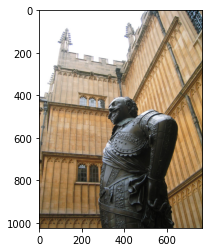

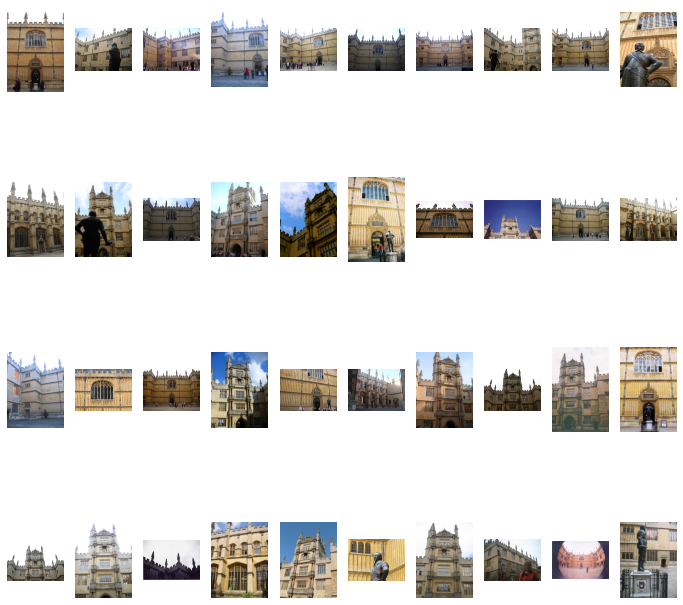

In [ ]:
query = Image.open(query_path) 
show_imgs(query, normal_ids)

## Gap metric

In [ ]:
def gap(pred, conf, true, return_x=False):
    """
    Compute Global Average Precision (aka micro AP), the metric for the
    Google Landmark Recognition competition.
    This function takes predictions, labels and confidence scores as vectors.
    In both predictions and ground-truth, use None/np.nan for "no label".
    Args:
        pred: vector of integer-coded predictions
        conf: vector of probability or confidence scores for pred
        true: vector of integer-coded labels for ground truth
        return_x: also return the data frame used in the calculation
    Returns:
        GAP score
    """
    x = pd.DataFrame({'pred': pred, 'conf': conf, 'true': true})
    x.sort_values('conf', ascending=False, inplace=True, na_position='last')
    x['correct'] = (x.true == x.pred).astype(int)
    x['prec_k'] = x.correct.cumsum() / (np.arange(len(x)) + 1)
    x['term'] = x.prec_k * x.correct
    gap = x.term.sum() / x.true.count()
    if return_x:
        return gap, x
    else:
        return gap

In [ ]:
# def pred_imgs(query, f_ids, columns, rows):
#   """
#   It takes in a query image and a list of filepaths to images, and displays the query image and the
#   top 20 images from the list of filepaths
  
#   :param query: the image we want to find similar images to
#   :param f_ids: the list of file ids of the images that are most similar to the query image
#   """
#   output_query_imgs = [] 
#   for i in range(1, columns*rows +1):
#     img = mpimg.imread(id2img_fps[f_ids[i - 1]])
#     landmark_id = landmarkid2img_fps[f_ids[i - 1]]
#     output_query_imgs.append(landmark_id)
#   output_query_imgs.reverse()
#   return output_query_imgs

In [ ]:
columns = 10
rows = 4

root_img_path = '/content/data'
df = pd.read_csv(os.path.join(root_img_path, 'train.txt'), header=0)
files = df['landmark_id']
landmarkid2img_fps = dict(enumerate(files))

# pred = pred_imgs(query, normal_ids, columns, rows)

pred1=[]
for i in normal_ids+2 :
  pred1.append(landmarkid2img_fps[i-2][1])

true1=[]
for i in range(columns*rows):
  true1.append(query_id)
print(len(true1))

gap,x =gap(pred=pred1, conf=normal_scores, true=true1, return_x=True)

In [ ]:
gap

1.0

In [ ]:
x

,pred,conf,true,correct,prec_k,term
39,3,61.493626,3,1,1.0,1.0
38,3,60.053692,3,1,1.0,1.0
37,3,59.758507,3,1,1.0,1.0
36,3,58.548340,3,1,1.0,1.0
35,3,58.125740,3,1,1.0,1.0
34,3,56.750011,3,1,1.0,1.0
33,3,55.460762,3,1,1.0,1.0
32,3,55.219807,3,1,1.0,1.0
31,3,54.527599,3,1,1.0,1.0
30,3,54.293335,3,1,1.0,1.0


### Dùng wandb để vẽ Gap metric

In [ ]:
wandb.log({'table':x})